In [1]:
from IPython.core.display import HTML
HTML("<style>.container { width:95% !important; }</style>")

# Steepest descent and Newton's method

## Let us define the same function as on the previous lesson for testing

In [2]:
def f_simple(x):
    return (x[0] - 10.0)**2 + (x[1] + 5.0)**2+x[0]**2

## Gradient-based optimization

If gradients are available, they should always be used --> improve convergence

If analytical formulas of the gradients are not available, they can be numerically approximated by using finite differences ($ℎ>0$)
* forward difference: $\frac{f(x+h)-f(x)}{h}=\nabla f(x)+O(h)$
* central difference: $\frac{f(x+h)-f(x-h)}{2h}=\nabla f(x)+O(h^2)$
* central difference is more accurate but requires twice as many function evaluations (in $𝑥+ℎ$ and $𝑥−ℎ$)

Gradient-based methods usually converge to a local minimum which is nearest to the starting point

## Automatic differentiation in Python

An alternative way is to use automatic differentiation

https://en.wikipedia.org/wiki/Automatic_differentiation

Import automatic differentiation package for Python

Needs to be installed typing
```
pip install ad
```

You can ask for gradient and hessian using the <pre>ad.gh</pre> function. Let us do that for the function <it>f</it>  that we defined.

In [3]:
import ad
grad_f, hess_f = ad.gh(f_simple)

In [4]:
print("At the point (1,2) gradient is ", grad_f([1,2]), " and hessian is ",hess_f([1,2]))

At the point (1,2) gradient is  [-16.0, 14.0]  and hessian is  [[4.0, 0.0], [0.0, 2.0]]


### Let us visualize the gradient

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from pylab import meshgrid
def visualize_gradient(f,point,x_lim,y_lim):
    grad_point = np.array(ad.gh(f)[0](point))
    grad_point = grad_point/np.linalg.norm(grad_point)
    X,Y,Z = point[0],point[1],f(point)
    U,V,W = grad_point[0],grad_point[1],0
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.arange(x_lim[0],x_lim[1],0.1)
    y = np.arange(y_lim[0],y_lim[1],0.1)
    X2,Y2 = meshgrid(x, y) # grid of point
    Z2 = [f([x,y]) for (x,y) in zip (X2,Y2)] # evaluation of the function on the grid
    Z2 = np.asarray(Z2)
    surf = ax.plot_surface(X2, Y2, Z2,alpha=0.5)
    ax.quiver(X,Y,Z,U,V,W,color='red',linewidth=2.5)
    return plt
    

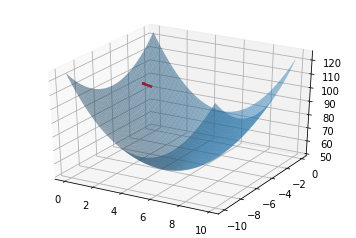

In [6]:
visualize_gradient(f_simple,[1,-2],[0,10],[-10,0]).show()

With the lambda function we can easily visualize gradients of various functions

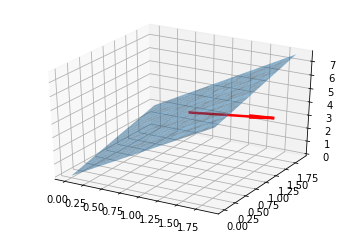

In [7]:
import math 
visualize_gradient(lambda x:3*x[0]+x[1],[1,1],[0,2],[0,2]).show()

## Base algorithm for the steepest descent and Newton's algorithms
**Input:** function $f$ to be optimized, starting point $x_0$, step length rule $alpha$, stopping rule $stop$  
**Output:** A solution $x^*$ that is close to a locally optimal solution
```
set f_old as a big number and f_new as f(x0)
while a stopping criterion has not been met:
    f_old = f_new
    determine search direction d_h according to the method
    determine the step length alpha
    set x = x + alpha *d_h
    f_new = f(x)
return x
```

The way to determine search direction distinguishes steepest descent algorithm and the Newton algorithm. Different stopping rules and step sizes can be mixed and matched with both algorithms.

## Steepest Descent algorithm for unconstrained optimization

Also known as *gradient descent* or *gradient method*

In the steepest descent algorithm, the search direction is determined by the negative of the gradient $-\nabla f(x)$.

### Code in Python

Let us use a simple stopping rule, where we stop when the change is not bigger than precision and we have a fixed step size.

In [8]:
import numpy as np
import ad
def steepest_descent(f,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steps = []
    f_new = f(x)
    d = float('Inf')
    while abs(f_old-f_new)>precision:
    #while np.linalg.norm(d)>precision:
        f_old = f_new
        d = -np.array(ad.gh(f)[0](x))
        x = x+d*step
        f_new = f(x)
        steps.append(list(x))
    return x,f_new,steps

### Solve the problem using the Python function

In [9]:
start = [2.0,-10.0]
(x_value,f_value,steps) = steepest_descent(f_simple,start,.2,0.01)
print("Optimal solution is ",x_value)
print(len(steps))

Optimal solution is  [ 4.99999846 -5.05038848]
9


Plot the steps of solving

In [10]:
import matplotlib.pyplot as plt

def plot_2d_steps(steps,start):
    myvec = np.array([start]+steps).transpose()
    plt.plot(myvec[0,],myvec[1,],'ro')
    for label,x,y in zip([str(i) for i in range(len(steps)+1)],myvec[0,],myvec[1,]):
        plt.annotate(label,xy = (x, y))
    return plt

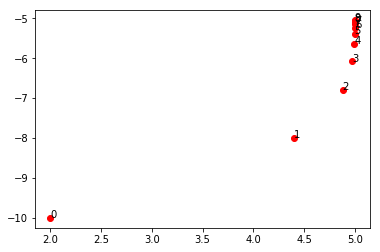

In [11]:
plot_2d_steps(steps,start).show()

In [12]:
def f_simple2(x):
    return (x[0] - 2.0)**4 + (x[0] - 2.0*x[1])**2
# Optimal solution is (2,1)

In [13]:
start = [0.0,3.0]
(x_value,f_value,steps) = steepest_descent(f_simple2,start,.02,0.0001)
print("Optimal solution is ",x_value)
print(len(steps))
#print(steps)

Optimal solution is  [1.88420207 0.94745017]
27


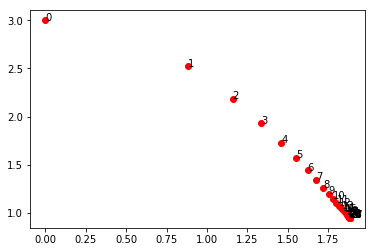

In [14]:
plot_2d_steps(steps,start).show()

Compare steepest descent with optimized step size:
![](images/steepest_descent.png)
*From Miettinen: Nonlinear optimization, 2007 (in Finnish)*

## Newton's method

Based on setting the research direction as $-[Hf(x)]^{-1}\nabla f(x)$.

In one-dimensional case, it is easy to see that since
$$f(x+\Delta x)\approx f(x)+f'(x)\Delta x+\frac12f''(x)\Delta x^2$$
with the Taylor series.

We want to find $x$ such that $f(x)$ is at minimum and, thus, we seek to solve the equation that sets the derivative of this expression with respect to $\Delta x$ equal to zero:

$$ 0 = \frac{d}{d\Delta x} \left(f(x_n)+f'(x_n)\Delta x+\frac 1 2 f''(x_n) \Delta x^2\right) = f'(x_n)+f'' (x_n) \Delta x.$$

The solution of the above equation is $\Delta x=-f'(x_n)/f''(x_n)$. Thus, the best approximation of $x_{n+1}$ as the minimum is $x_n-f''(x_n)^{-1}f'(x_n)$.


In [15]:
def newton(f,start,step,precision):
    f_old = float('Inf')
    x = np.array(start)
    steps = []
    f_new = f(x)
    while abs(f_old-f_new)>precision:
        f_old = f_new
        H_inv = np.linalg.inv(np.matrix(ad.gh(f)[1](x)))
        d = (-H_inv*(np.matrix(ad.gh(f)[0](x)).transpose())).transpose()
        #Change the type from np.matrix to np.array so that we can use it in our function
        x = np.array(x+d*step)[0]
        f_new = f(x)
        steps.append(list(x))
    return x,f_new,steps

In [16]:
start = [2.0,-10.0]
(x_value,f_value,steps) = newton(f_simple,start,0.2,0.0001)
print("Optimal solution is ",x_value)
print(len(steps))

Optimal solution is  [ 4.99419716 -5.00967141]
28


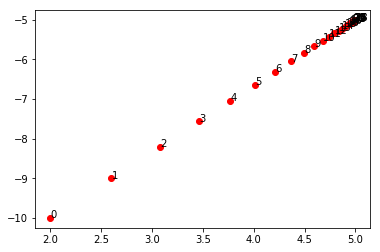

In [17]:
plot_2d_steps(steps,start).show()

In [20]:
start = [0.0,3.0]
(x_value,f_value,steps) = newton(f_simple2,start,0.2,0.0001)
print("Optimal solution is ",x_value)
print(len(steps))

Optimal solution is  [1.94797541 0.97398771]
9


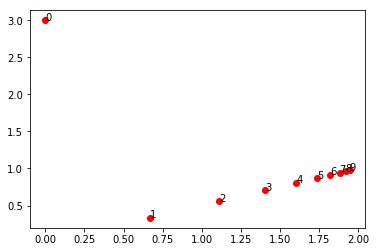

In [21]:
plot_2d_steps(steps,start).show()

Compare Newton's method with step size = 1.0:
![](images/newton.png)
*From Miettinen: Nonlinear optimization, 2007 (in Finnish)*

# Summary

Steepest descent
* Descent direction: yes
* Global convergence: yes
* Local convergence: zig-zag near optimum
* Computational bottle neck: step length
* Memory consumption: $𝑂(𝑛)$

Newton’s method
* Descent direction: only if $𝐻f(𝑥)^{−1}$ positive definite
* Global convergence: no
* Local convergence: yes, good if 𝑓 quadratic
* Computational bottle neck: $𝐻f(𝑥 )^{−1}$ --> can be relaxed by using approximations of $Hf(x)^{-1}$ --> quasi-Newton
* Memory consumption: $𝑂(𝑛^2)$ --> can be reduced e.g. by using conjugate gradient methods